# Problem set 6: Classification

## Description

Explore different algorithms to classify Old Bailey cases as involving "stealing" or "other."

## Imports and setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
# Our input text file
old_bailey_file = os.path.join('..', '..', 'data', 'old_bailey', 'old_bailey.txt')

## Old Bailey records

We'll work with a set of 3,090 short text documents from the Old Bailey archive, just as we did last week.

In [2]:
# Read cases in as a list of strings
with open(old_bailey_file, 'r') as f:
    bailey = [doc for doc in f.read().split('\n\n')] # split on consecutive newlines
print("Total documents:", len(bailey))

Total documents: 3090


In [3]:
# Freebie function to assign gold labels to corpus texts
def make_labels(corpus, keyword='steal'):
    '''
    Takes a corpus of documents and a keyword string.
    Assigns labels based on coöccurrence of keyword and ' indicted for ' in first sentence of document.
    Returns an array of class labels (1=member, 0=nonmember).
    '''
    from nltk import word_tokenize, sent_tokenize
    import re
    find_indictment = re.compile(' indicted for ')
    find_keyword = re.compile(keyword)
    labels = []
    for doc in corpus:
        first_sentence = sent_tokenize(doc)[0].lower()
        if find_indictment.search(first_sentence) and find_keyword.search(first_sentence):
            labels.append(1)
        else:
            labels.append(0)
    return np.array(labels)

In [4]:
# Generate gold labels
y_bailey = make_labels(bailey, keyword='steal')
print("Label vector shape:", y_bailey.shape)
print("Stealing cases:", np.sum(y_bailey))
print("Fraction of cases labeled 'stealing':", round(np.sum(y_bailey)/len(y_bailey),3))

Label vector shape: (3090,)
Stealing cases: 2676
Fraction of cases labeled 'stealing': 0.866


In [5]:
# Baseline accuracy and F1
#  What if we just guess 1 every time?
baseline_accuracy = np.sum(y_bailey)/len(y_bailey)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.866
Baseline F1: 0.928


## 1. Vectorize (5 points)

Using the vectorizer defined below, transform the input documents into a TFIDF-weighted document-term matrix. Store your vectorized output in a varaible named `X_bailey` and print the shape of the resulting matrix.

Note: This is a straight carry-over from the last problem set.

In [6]:
# Custom preprocessing to remove escaped characters in input
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True # And this
)

In [7]:
X_bailey = vectorizer.fit_transform(bailey)

In [8]:
# Get the dimensions of the doc-term matrix
print("Matrix shape:", X_bailey.shape)

Matrix shape: (3090, 8638)


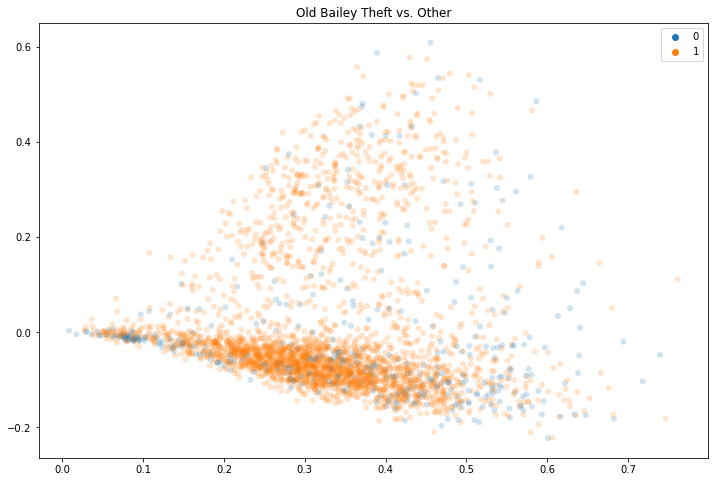

In [9]:
# Freebie: plot our data
coords_bailey = TruncatedSVD(n_components=2).fit_transform(X_bailey)

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=coords_bailey[:, 0], 
    y=coords_bailey[:, 1],
    hue=y_bailey,
    alpha=0.2,
    linewidth=0
)
plt.title('Old Bailey Theft vs. Other')
plt.show()

## Freebies: Classification and cross-validation how-to

Below is a sample of how to set up classifiers and perform cross-validation.

In [10]:
# Cross-validate two simple classifiers on our data
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_bailey, # feature matrix
        y_bailey, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [11]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [12]:
# Compare cross-validation scores
# Note that colorization of the `time` columns is counterintuitive
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.003482,0.108313,0.872492,0.925005,0.746616,0.872492
Logit,0.126191,0.002540,0.909709,0.950408,0.721966,0.909709


## 2. Add results from three more classifiers (25 points)

* Set up the three classifiers imported below (decision tree, random forest, and multinomial naïve Bayes). Use **default** parameters only (that is, do not set any classifier parameters yourself). (10 points total)
* Cross-validate the three new classifiers, saving the scoring output to the same `scores` dictionary as above. (10 points)
* Use the `compare_scores` function to display the scores of all five classifiers. (5 points)

This all takes less than 30 seconds total to run on my laptop.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [15]:
classifiers_new = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'Bayes': MultinomialNB()
}
scores_new = {} 
for i in classifiers_new: 
    scores_new[i] = cross_validate( 
        classifiers_new[i], 
        X_bailey, 
        y_bailey, 
        cv=10, 
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] 
    )
#from code above

In [16]:
compare_scores(scores_new)

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
DecisionTree,0.448006,0.005463,0.957282,0.975371,0.906951,0.957282
RandomForest,1.307194,0.032028,0.950485,0.972216,0.871643,0.950485
Bayes,0.004762,0.002933,0.874757,0.932580,0.525308,0.874757


## 3. Compare the unoptimized performance of the five classifiers (10 points)

How would you summarize the performance of the five classifiers prior to any optimization? Consider classification performance relative to one another and to baseline, as well as computation time. 

**Each of the five classifiers had a higher accuracy score than the baseline accuracy score of ~86%**. However, it seemed that just under half of the classifiers did not break 90% accuracy. It seemed that the **"tree" classifiers (Decision Tree and Random Forest) did much better than the other classifers**. **Bayes and KNN did the most poorly**, they had basically a 1% differential with the baseline score. Moving away from accuracy scores, looking at the fit times, **it could be said that those with lower performance scores were much, much faster when fitting**. This is interesting, and **makes you think about the correlation (if any) between fit time and accuracy**. Is fit time longer, because the classification is more intricate leading to a better accuracy score? This is hard to say, however, I think **generally the classifiers were alright, clearly some were much better than others**, and it seems there might be a **fit time correlation with test accuracy**. 

## 4. Improve two of the classifiers (40 points)

See how much you can improve the performance of any two of the five classifiers. You might try:

* Changing the vectorization parameters. (Hint: it can help to use fewer input features).
* Changing the classifier parameters. 
    * See the `sklearn` [documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for your chosen classifiers for a list of available options.
* Trying a different classifier entirely.
    * If you do this, make sure you give careful consideration to the settings of the new classifier, too. **Using default parameters will result in a score of zero.**
    
No matter what you try, you must **document your process**. In other words, don't just change settings in a cell and run it over and over. You should iterate over different options, storing your cross-validation scores for each combination of settings.

Finally, display your results using the `compare_scores` function.

Points breakdown: 20 points total for each classifier, of which 10 are for iterating over a range of parameter values, 5 are for performing cross validation correctly and displaying summary scores, and 5 are for actually improving performance (by any amount). 

In [18]:
#trying to improve KNN classifier 
#I am looking at neighbors because it seems to be an important parameter when looking at the classifier 
neighbors = range(1, 41) # here I am setting a range regarding the neighbors to iterate by 
scores_knn = [] #I made an empty list to append the mean scores from cross validating
for i in neighbors:
    model = KNeighborsClassifier(n_neighbors = i)
    knn_scored = cross_validate(model,X_bailey,y_bailey,cv=10,scoring='accuracy') #here we are only looking at accuracy
    #since that could be seen as the most important metric and we are only switching the n_neighbors to see if accuracy will improve
    knn_scored = knn_scored['test_score'].mean() #mean per 10 cross validations
    scores_knn.append(knn_scored)

In [19]:
print(scores_knn.index(max(scores_knn)), max(scores_knn)) #finding the index and score (31 index = 32 neighbors)

31 0.9255663430420713


Text(0, 0.5, 'Accuracy')

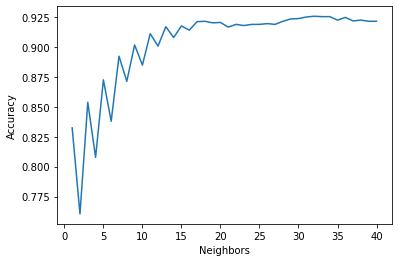

In [33]:
plt.plot(neighbors, scores_knn) #now we are plotting to see the highest accuracy for neighbors 
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')

In [21]:
improved_neighbors = range(30, 40) #now we are looking at a specific range based on the graph above 
new_scores_knn = []
for i in improved_neighbors:
    model = KNeighborsClassifier(n_neighbors = i)
    knn_scored = cross_validate(model,X_bailey,y_bailey,cv=10,scoring='accuracy')
    knn_scored = knn_scored['test_score'].mean()
    new_scores_knn.append(knn_scored)

Text(0, 0.5, 'Accuracy')

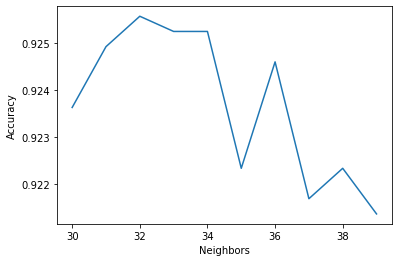

In [34]:
plt.plot(improved_neighbors, new_scores_knn) #same plotting method as above
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')

In [36]:
improvement1_KNN = { 
    'KNN': KNeighborsClassifier(),
    'KNN_improved': KNeighborsClassifier(n_neighbors = 32),
}
improved1_scores_KNN = {} 
for i in improvement1_KNN: 
    improved1_scores_KNN[i] = cross_validate( 
        improvement1_KNN[i], 
        X_bailey, 
        y_bailey, 
        cv=10, 
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] 
    )

In [37]:
compare_scores(improved1_scores_KNN) #comparing the scores of new KNN and old KNN scores

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
KNN,0.003473,0.105093,0.872492,0.925005,0.746616,0.872492
KNN_improved,0.002844,0.104008,0.925566,0.958154,0.808717,0.925566


In [29]:
n_neighbors = [i for i in range(1,40)] #now I wanted to look at some more parameters to see if the accuracy will improve
alg = ['ball_tree', 'kd_tree','brute', 'auto']
params = {'n_neighbors':n_neighbors,'weights':['uniform','distance'], 'algorithm':alg} #parameters I want to see 
grid_KNN = GridSearchCV(KNeighborsClassifier(),params, cv = 10) #using GridSearchCV (documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
grid_KNN_result = grid_KNN.fit(X_bailey,y_bailey) #fitting data, this takes a couple min 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

In [30]:
print(grid_KNN_result.best_params_) 
print(grid_KNN_result.best_score_) #we can see that this will give us the best accuracy per given parameters

{'algorithm': 'ball_tree', 'n_neighbors': 33, 'weights': 'distance'}
0.9258899676375405


In [38]:
improvement_KNN_final = { 
    'KNN_improved': KNeighborsClassifier(n_neighbors = 32),
    'KNN_improved_parameters': KNeighborsClassifier(n_neighbors = 33, algorithm = 'ball_tree', weights = 'distance')
}
improved_scores_KNN = {} 
for i in improvement_KNN_final: 
    improved_scores_KNN[i] = cross_validate( 
        improvement_KNN_final[i], 
        X_bailey, 
        y_bailey, 
        cv=10, 
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] 
    )

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute 

In [39]:
compare_scores(improved_scores_KNN) #slight improvement- going to use gridsearchcv for other improvements 

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
KNN_improved,0.006741,0.151099,0.925566,0.958154,0.808717,0.925566
KNN_improved_parameters,0.003437,0.099982,0.925890,0.958465,0.805154,0.925890


In [41]:
# trying to improve multinomial Naive Bayes
# I wanted to look at the additive smoothing- which is the alpha in MultinomialNB- is used to "smooth" the data, which 
#basically means to use approximations at certain points of the data
#lower alpha means less smoothing
grid_NB = GridSearchCV(MultinomialNB(),{'alpha': [1,.5,.25,.1,.05,.01,.001,.0001]}, cv = 10) 
grid_res_NB = grid.fit(X_bailey, y_bailey) 
print(grid_res_NB.best_params_) 
print(grid_res_NB.best_score_)

{'alpha': 0.01}
0.9323624595469255


In [39]:
improvement_NB = {
    'Bayes': MultinomialNB(),
    'Bayes_improved': MultinomialNB(alpha = 0.01)
}
improved_score_NB = {} 
for i in improvement_NB: 
    improved_score_NB[i] = cross_validate( 
        improvement_NB[i], 
        X_bailey, 
        y_bailey, 
        cv=10, 
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] 
    )
compare_scores(improved_score_NB)#comparing old to improved NB classification, also looks like longer fit times do not mean better accuracy

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
Bayes,0.010347,0.003876,0.874757,0.932580,0.525308,0.874757
Bayes_improved,0.003655,0.002621,0.932362,0.961876,0.830423,0.932362


## 5. Examine and discuss classification errors (20 points)

First, rerun your best-performing classifier over the full corpus and save the resulting labels as `y_best`. (10 points)

To do this, first set up a classifier with your optimized paramters; then use the classifier's `fit` method to train the model; then use the fitted classifer's `predict` method to compute the labels. In schematic form, this looks like:

```
y_labels = Classifier(options).fit(X, y).predict(X)
```

(Note that training and testing over the same data is poor practice, since it encourages overfitting. We avoided that problem by using cross validation above. We're doing it here only for ease of examination.)

Then use the `pull_errors` function below to read through some cases that were incorrectly classified by your best-perfoming classifer. Write a paragraph that summarizes any patterns you can identify in the mis-classified cases. Can you explain what may be confusing the classifier? Does your analysis suggest any avenues for improved performance? (10 points)

In [36]:
#Can't use DecisionTreeClassifier since, as stated on Campuswire(https://campuswire.com/c/G279E2961/feed/149), an error will be returned
#I decided to use the classifier that most improved from its original, which was the MultinomialNB (slightly improved more than KNN)
y_best = MultinomialNB(alpha = .01).fit(X_bailey,y_bailey).predict(X_bailey)

In [37]:
# Function to examine some classification errors
def pull_errors(labels, gold_labels=y_bailey, corpus=bailey, n=3):
    '''
    Takes:
        an array of computed labels
        an array of gold (correct) labels
        a list of corpus documents
        an int of cases to display
    '''
    import pandas as pd
    labeled_cases = pd.DataFrame(
        {
            'gold':gold_labels, 
            'computed':labels,
            'text':corpus
        }   
    )
    errors = labeled_cases.loc[labeled_cases.gold != labeled_cases.computed]
    with pd.option_context('display.max_colwidth', None):
        display(errors.sample(n))

In [38]:
# Pull errors
pull_errors(y_best, y_bailey, bailey, n=3)

,gold,computed,text
1226,0,1,"was indicted for embezzling one half crown, the property of , his employer . SECOND COUNT for stealing a half crown. MR. BRODRICK conducted the Prosecution. . I am a grocer , and live in Drury-lane . The prisoner lived shopman with me for a year and a half; it was his duty to receive money. On the 14th of November , about six o'clock, my wife and I went out, leaving him and Taylor in the shop. I returned about twelve, and in consequence of a communication from Taylor, I saw the prisoner in his presence, and desired him to produce his money from his pocket; he produced 25 s. Taylor selected and identified a half crown from among it. I said, ""Tew, how much have you taken out of the till to-day?"" He said, ""I had 10 s. in the morning, and the other 15 s. I have taken from the till to-day.."" . I am employed by the prosecutor. He left me with the prisoner. I marked three half crowns in Shaw's presence in the back parlour. Shaw took them away. I afterwards saw two of the same in the till, the other was missing, and found on the prisoner's person - this is it, (looking at one). . I am a chemist. I saw the half crowns marked, and gave them to Brown, and followed him to Prestwidge's shop, where he bought some tea. . I am servant to Mr. Day. I received three half crowns and took them to Prestwidge's, and gave them to the prisoner for one pound of 7 s. tea. . I am an officer. I produce the 15 s. . Here is one half crown among them which I marked. GUILTY . Aged 46. Transported for Seven Years . First Middlesex Jury, before Mr. Recorder."
323,0,1,"was indicted for feloniously assaulting , on the King's highway, on the 8th of November , at St. Marylebone , putting him in fear, and taking from his person and against his will, three seals, value 15 s.; two keys, value 2 s. 6 d., and part of a watch-chain, value 2 s. 6 d., his property . . I keep the French Horn, public-house, in Beach-street, Barbican . On the 8th of November, about ten o'clock at night, I was in Cheapside , going home quite sober; the prisoner came against me near the passage leading to Honey-lane market, and at the same time laid hold of my watch-chain which broke, he ran off with part of it and the seals - he knocked me against the corner of the passage, if that had not stopped me I must have fell. I pursued calling Stop thief! and a man stopped him at the corner of the passage just by the public-house door, before he entered the market. I never lost sight of him - I saw him throw the seals behind him. Hoddy brought a candle, and picked them up with part of the chain. . I am an officer. I heard the cry of Stop thief! when I was in my shop in the market; I ran out, and stopped the prisoner turning round by the public-house, Walsh was just behind him. I took him into the public-house - Huddy went out, and found the seals and part of the chain. . I am a pot-boy. I found the seals, and part of the chain three or four feet from where the officer seized the prisoner - he was brought into the house. (Property produced and sworn to.) . I am an officer. Smith delivered me the seals at the watch-house. The prisoner begged for mercy. GUILTY - DEATH . Aged 21. London Jury, before Mr. Common Sergeant.\nSECOND DAY, THURSDAY, DECEMBER 7. 15. , and were indicted for stealing, on the 17th of November , six brass weights, value 2 s. , the goods of . ELIZA M'DONALD. I am the wife of Andrew M'Donald, and keep a chandler's shop . On the 17th of November, about half-past eleven o'clock in the morning, the weights were in the scales; six boys entered the shop, and I immediately missed the weights - I believe the prisoners to be three of the boys. . I am a baker. Mrs. M'Donald said she missed her weights, I ran after the boys, and saw Adams come out of a shop with some bacon, and Mawley following him. I secured them. . I found the weights on Adams. (Property produced and sworn to.) NOT GUILTY . Second Middlesex Jury, before Mr. Recorder."
2536,0,1,"was indicted fo

Well it seems that all of the mislabelings were a result of the classifier thinking a document belonged to label 1 (labeled above as meaning a document having to do with stealing). When looking at the three documents returned by pull_errors, it is possible to see that 2/3 of these documents did include the keyword "steal" and all began with "was indicited for." Initially, I thought the keyword being in the documents was the culprit for causing the classifer confusion, however, after further inspection, it showed that the last document in fact did not contain the keyword "steal." This got me thinking about why the classifier had mislabeled this document. While reading the document, the word "seal" came up quite frequently, and I think that might be what is confusing the classifier. The third document has the same introduction ("was indicited for"), and a word that looks similar to the keyword ("seal"), and I think it would be safe to assume, that the classifier mistook "seal" for "steal" causing its inclusion in the label 1. This leads me to think that there can be improvement, instead of just setting the keyword as "steal," maybe some sort of meaning detection or specified idea of stealing. To clarify, embezzelment is a type of theft, and technically the classifier would be right if accounting for all accounts of theft/stealing, but in cases like this, it is mislabeled. So maybe being more specific could be an avenue to explore. 